In [1]:
import os
import sys
import json
import os
import json
import subprocess
import numpy as np

from collections import defaultdict


from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

# Plotting
%matplotlib inline
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# For MB Pro retina display
%config InlineBackend.figure_format = 'retina'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

import nb_utils as nb_utils
sys.path.append('../')
import profiler
import utils
from profiler import ProfileRun
from pprint import pprint

In [2]:
import torch

from models import BigGAN, biggan, biggan_deep


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def run_G(resolution=128, batch_size=32, n_classes=1000, num_itr=500, outfile=None):
    G = biggan.Generator(resolution=128).to(device)
    z_, y_ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device)
    with torch.no_grad():
        for _ in range(num_itr):
            out = G(z_, y_, embed=True)
    del G, z_, y_
    return prof


def plot_usage(pr, gpu_index=0, smooth_amount=0.00):
    fig, axs = plt.subplots(5, sharex=True)
    
    time = pr.time_profile()
    power = pr.power_profile()
    gpu_power = pr.gpu_power_profile(gpu_index=gpu_index)
    util = pr.gpu_util_profile(gpu_index=gpu_index)
    mem = pr.gpu_mem_profile(gpu_index=gpu_index)
    temp = pr.gpu_temp_profile(gpu_index=gpu_index)
    
    for label, data, ax in zip(['Power', 'GPU Power', 'Util', 'Memory', 'Temperature'],
                               [power, gpu_power, util, mem, temp], axs.flat):
        ax.plot(time, data)
        ax.set(ylabel=label)

    plt.xlabel('Time (sec)', fontsize='x-large')
    axs[0].set_title('Profiling Summary', fontsize='xx-large')
    fig.tight_layout()
    plt.show()

In [3]:
with profiler.Profile(outfile=None) as prof:
    run_G(batch_size=8)
    run_G(batch_size=16)
    run_G(batch_size=32)
    run_G(batch_size=64)
    run_G(batch_size=128)
    run_G(batch_size=256)

In [4]:
profile_run = ProfileRun(prof.data)

Total time:      338.548378
Total Power:     0.5459928684106706 Wh
Total GPU Power: 0.19063745152546557 Wh


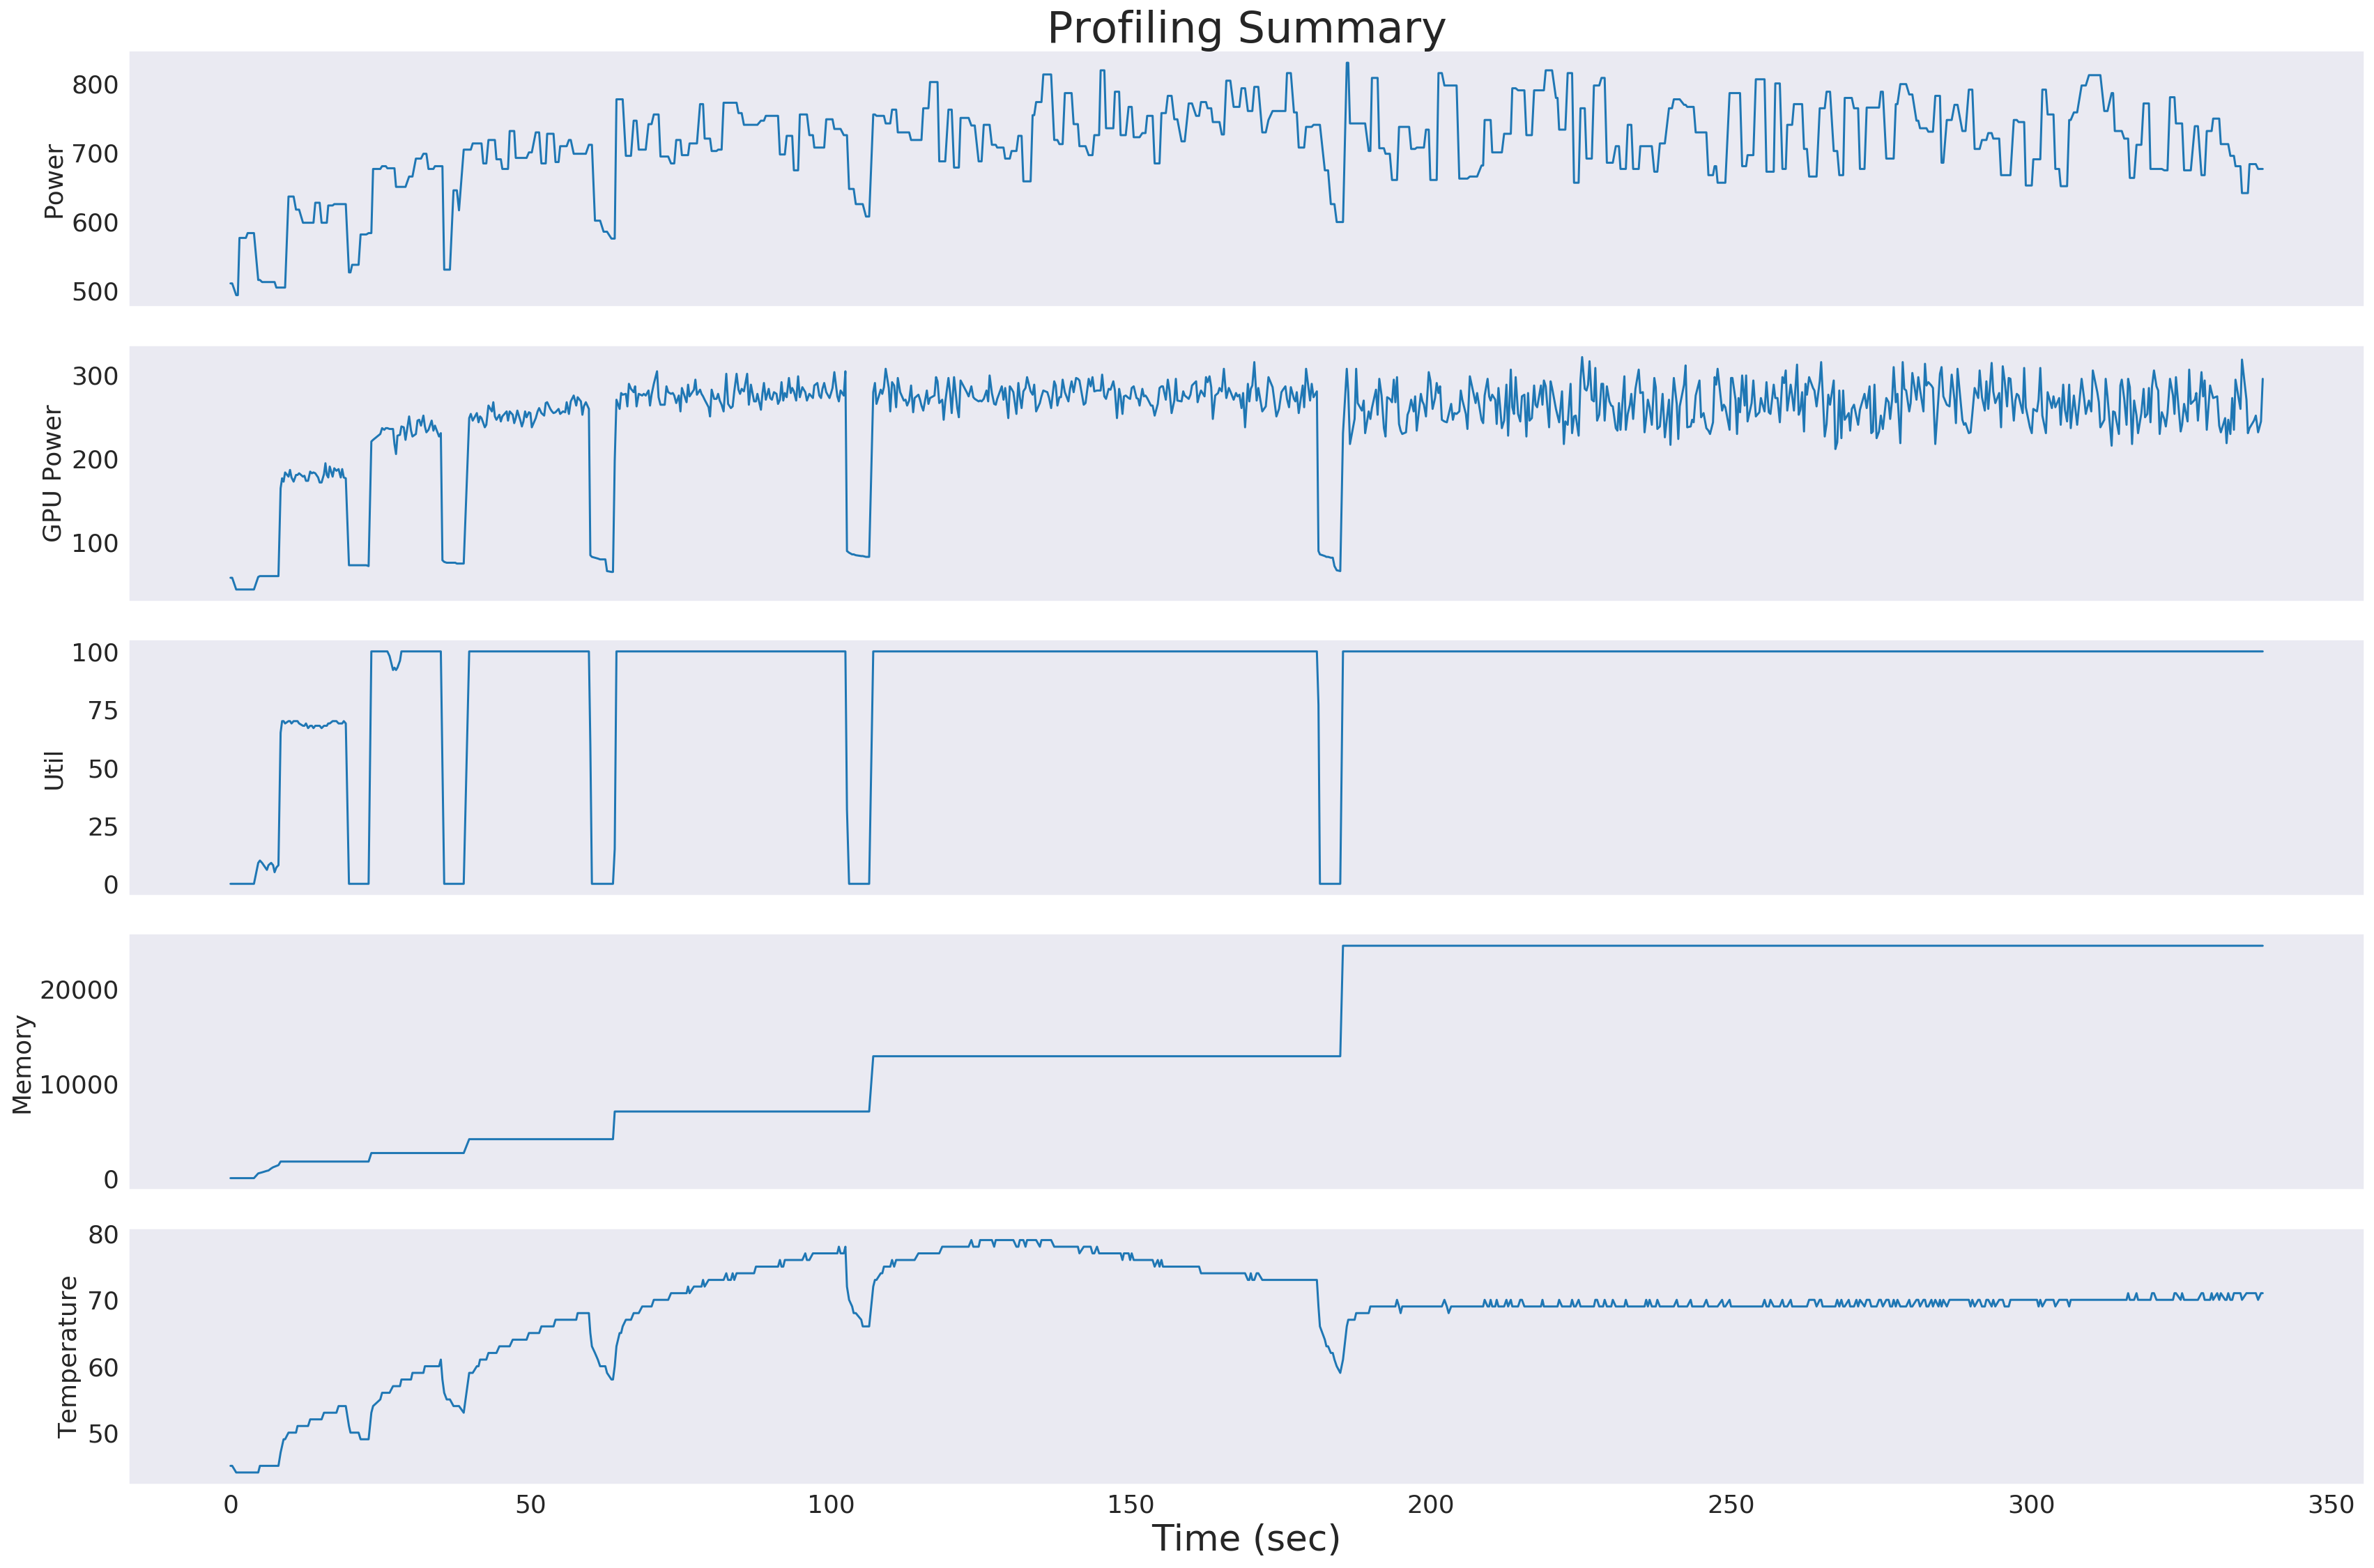

In [10]:
gpu_index = 0
profile_run.print_stats(gpu_index=gpu_index)
plot_usage(profile_run, gpu_index=gpu_index)